In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

# Loader

In [2]:
import torch
import torchvision
from torchvision.transforms import v2
from PIL import Image
import os

SPLIT_RANDOM_SEED = 42


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirname, labels, transform=None):
        super().__init__()
        self._image_dirname = image_dirname

        self._transform = transform
        if self._transform is None:
            self._transform = v2.Compose([
                torchvision.transforms.ToTensor()])

        self._labels = labels

    def __len__(self) -> int:
        return len(self._labels)

    def __getitem__(self, item):
        label, filename = self._labels.iloc[item]['Category'], self._labels.iloc[item]['Id']
        image = Image.open(os.path.join(self._image_dirname, filename)).convert('RGB')
        image = self._transform(image)
        return image, label


def get_loaders(image_dirname_test, labels_test, image_dirname, labels, train_transform, test_size, batch_size):
    test_transform = v2.Compose([
        torchvision.transforms.ToTensor(),
        v2.Normalize(mean=[0.5692, 0.5448, 0.4934], std=[0.1823, 0.1810, 0.1854])])
    train, val = torch.utils.data.random_split(range(len(labels)), [1 - test_size, test_size],
                                               torch.Generator().manual_seed(SPLIT_RANDOM_SEED))
    
    train_split = ImageDataset(image_dirname, labels.iloc[train.indices], transform=train_transform)
    val_split = ImageDataset(image_dirname, labels.iloc[val.indices], transform=test_transform)
    
    train_loader = torch.utils.data.DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_split, batch_size=batch_size, shuffle=False)
    
    test_split = ImageDataset(image_dirname_test, labels_test, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_split, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


# Train and Test

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()
    

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        val_loss, val_accuracy = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step(val_loss)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]
        
        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_accuracy)}")
        print(f" val loss: {val_loss}, val acc: {val_accuracy}\n")
        
    plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

    return train_losses, val_losses, train_accuracies, val_accuracies

In [8]:
import csv

def get_predict(model, test_dir):
    model.eval()
    test_labels = []

    test_transform = v2.Compose([
        torchvision.transforms.ToTensor(),
        v2.Normalize(mean=[0.5692, 0.5448, 0.4934], std=[0.1823, 0.1810, 0.1854]),
    ])

    for filename in os.listdir(f'{test_dir}'):
        image = Image.open(f'{test_dir}/{filename}').convert('RGB')
        input = test_transform(image).unsqueeze(0).to(device)
        logits = model(input)
        test_labels.append({'Id': filename, 'Category': logits.argmax(dim=1).item()})

    with open('labels_test.csv', 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, ('Id', 'Category'))
        dict_writer.writeheader()
        dict_writer.writerows(test_labels)
        

In [36]:
get_predict(net, 'test')

# Resnet 50

In [6]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 4  

    def __init__(self, in_channels, channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        
        self.conv3 = nn.Conv2d(channels, channels * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  
    
    def forward(self, x):
        identity = x  

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  
        out = self.relu(out)

        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1000): 
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=4, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.7, inplace=True)
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)
    
    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * block.expansion),
            )

        layers = []
    
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)    
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)   
        x = self.layer2(x)   
        x = self.layer3(x)   
        x = self.layer4(x)   

        x = self.avgpool(x)  
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)     

        return x

    
import pandas as pd
labels = pd.read_csv('labels.csv')
n_classes = labels['Category'].nunique()
model = ResNet50(num_classes=n_classes)
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

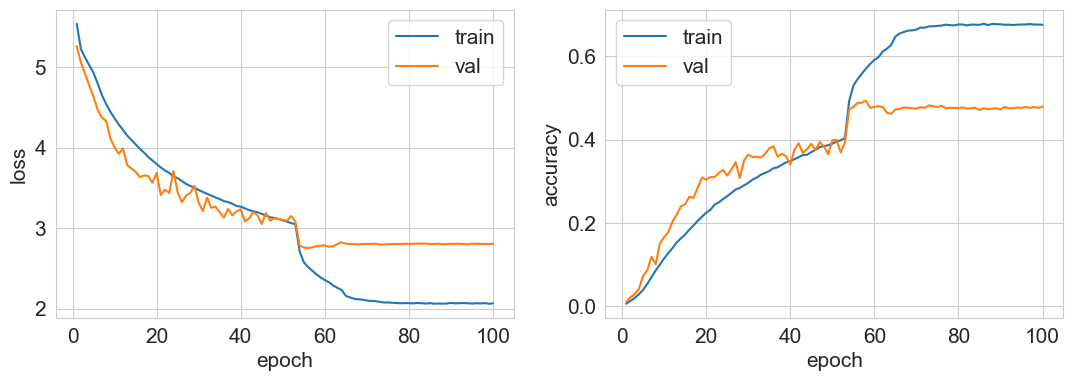

In [7]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.RandomChoice([v2.RandomHorizontalFlip(0.5), v2.RandomVerticalFlip(0.5)], p=[0.5, 0.5]),
    v2.RandomGrayscale(p=0.5),
    v2.RandomApply([
        v2.GaussianBlur(kernel_size=5)], p=0.5),
    torchvision.transforms.ToTensor(),
    v2.Normalize(
        mean=[0.5692, 0.5448, 0.4934], 
        std=[0.1823, 0.1810, 0.1854]
    ),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.25), ratio=(1.0, 1.0)),
])

train_loader, val_loader, test_loader = get_loaders(image_dirname_test='test', labels_test=pd.read_csv('sample_submission.csv'),
                                                    image_dirname='trainval', labels=pd.read_csv('labels.csv'),
                                                    train_transform=transform, test_size=0.01, batch_size=200)

net = model.to(device)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=7,      
    cooldown=1
)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, scheduler, criterion, train_loader, val_loader, 100)

In [11]:
import copy

net_45 = copy.deepcopy(net)

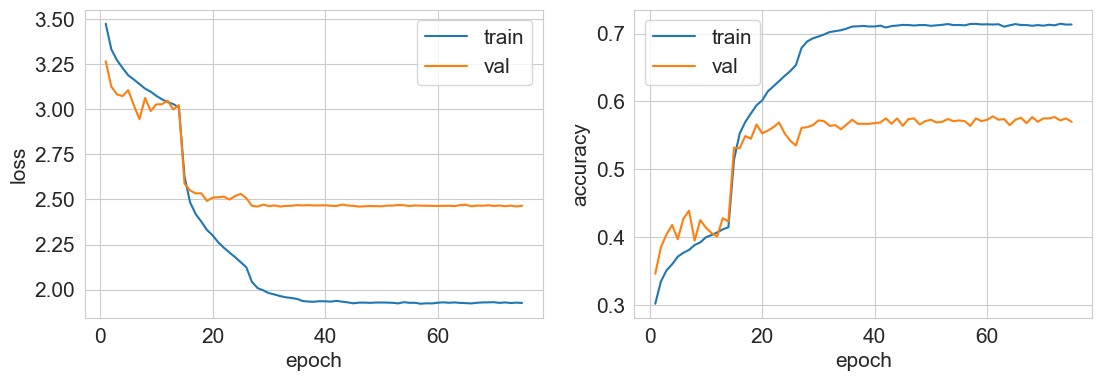

In [33]:
from torchvision import transforms

transform2 = v2.Compose([
    v2.RandomHorizontalFlip(0.5),
    v2.RandAugment(),
    torchvision.transforms.ToTensor(),
    v2.Normalize(
        mean=[0.5692, 0.5448, 0.4934], 
        std=[0.1823, 0.1810, 0.1854]),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.25), ratio=(1.0, 1.0)),
])

train_loader2, val_loader2, test_loader2 = get_loaders(image_dirname_test='test', labels_test=pd.read_csv('sample_submission.csv'),
                                                    image_dirname='trainval', labels=pd.read_csv('labels.csv'),
                                                    train_transform=transform2, test_size=0.01, batch_size=128)

model2 = copy.deepcopy(net_45)
net2 = model2.to(device)
criterion2 = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer2 = optim.SGD(net2.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2,
    patience=6,      
    cooldown=1
)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net2, optimizer2, scheduler2, criterion2, train_loader2, val_loader2, 75)

In [32]:
net_51 = copy.deepcopy(net2)

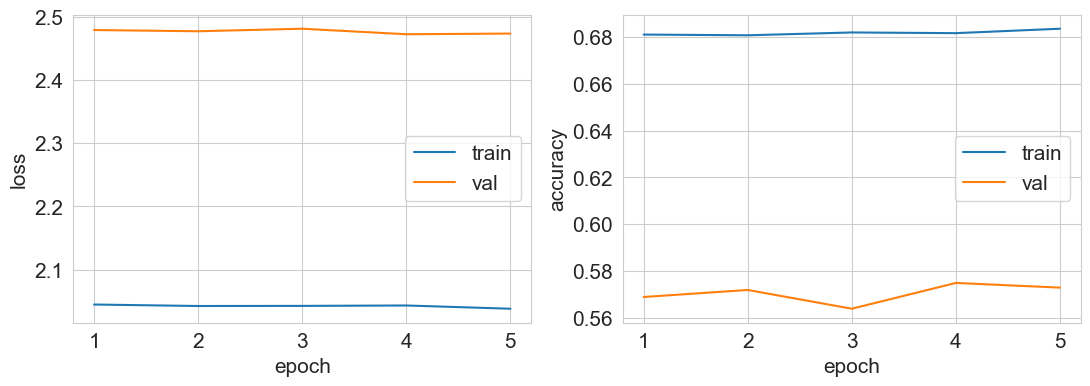

In [36]:
from torchvision import transforms

transform2 = v2.Compose([
    v2.RandomHorizontalFlip(0.5),
    v2.RandAugment(),
    torchvision.transforms.ToTensor(),
    v2.Normalize(
        mean=[0.5692, 0.5448, 0.4934], 
        std=[0.1823, 0.1810, 0.1854]),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.25), ratio=(1.0, 1.0)),
])

train_loader2, val_loader2, test_loader2 = get_loaders(image_dirname_test='test', labels_test=pd.read_csv('sample_submission.csv'),
                                                    image_dirname='trainval', labels=pd.read_csv('labels.csv'),
                                                    train_transform=transform2, test_size=0.01, batch_size=128)

model3 = copy.deepcopy(net_51)
net3 = model3.to(device)
criterion2 = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer3 = optim.SGD(net2.parameters(), lr=0.2, momentum=0.9, weight_decay=0.0001)
scheduler3 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2,
    patience=5,      
    cooldown=1
)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net3, optimizer3, scheduler3, criterion2, train_loader2, val_loader2, 5)

In [37]:
get_predict(net3, 'test')